# KC Housing data

We'll start by seeing if the location of a house has any impact on price. Then we'll think about how we could draw neighbourhoods to better split the data. Lastly we'll produce a method for deciding which set of three variables to use in model construction. This is done on the assumption that we're working for a buyer with limited funds who can only change a maximum of three variables for a particular property.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
import itertools as itt
import statsmodels.api as sm

%matplotlib inline

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# Change all unclear header names to ones we like

df = df.rename(columns={'date' : 'date_sold'})
df = df.rename(columns={'price' : 'price_sold'})
df = df.rename(columns={'view' : 'view_grade'})
df = df.rename(columns={'sqft_above' : 'sqft_not_basement'})
df = df.rename(columns={'sqft_living15' : 'sqft_living_15_neighbours'})
df = df.rename(columns={'sqft_lot15' : 'sqft_lot_15_neighbours'})

In [5]:
# We check to see what percentage of the columns containing NaN values are NaN.

print('View Grade ' + str(round(df.isna().sum()['view_grade']/len(df.view_grade) *100, 2)) + ' % NaN')

print('Waterfront ' + str(round(df.isna().sum()['waterfront']/len(df.waterfront) *100, 2)) + ' % NaN')

print('Year Renovated ' + str(round(df.isna().sum()['yr_renovated']/len(df.yr_renovated) *100, 2)) + ' % NaN')

View Grade 0.29 % NaN
Waterfront 11.0 % NaN
Year Renovated 17.79 % NaN


In [6]:
# There is a large majority of buildings with the same view grade and waterfront values 
# so using median does not affect the overall shape of the data.

df = df.fillna(value={'yr_renovated' : 0})
df = df.fillna(value={'view_grade' : df.view_grade.median()})
df = df.fillna(value={'waterfront' : df.waterfront.median()})

In [7]:
# Filling in incorrect basement values by calculating the living space subtract rest of space in lot 
# as basement is living space

df.sqft_basement = (df.sqft_living - df.sqft_not_basement)

In [8]:
# WHY INT64

df.date_sold = pd.to_datetime(df.date_sold)
df.yr_renovated = df.yr_renovated.astype('int64')

In [9]:
# Strange outliers
# There is a 33 bedroom house, after comparing this property with other 3 bedroom houses we decided that there had been a 
# typo in data entry and that the 33 bedrooms should become a 3 bedroom property

df.loc[df['bedrooms'] == 33]

,id,date_sold,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_grade,...,grade,sqft_not_basement,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living_15_neighbours,sqft_lot_15_neighbours
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [10]:
df.loc[df['bedrooms'] == 3].head(3)

,id,date_sold,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_grade,...,grade,sqft_not_basement,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living_15_neighbours,sqft_lot_15_neighbours
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [11]:
# So we change the 33 into a 3

df.loc[df['bedrooms'] == 33, 'bedrooms'] = 3

# Questions

## 1) How does the location affect the price?

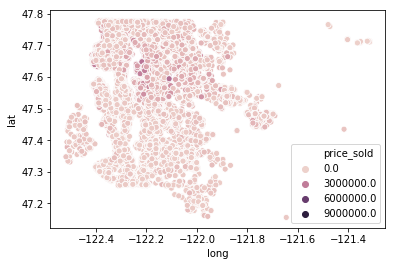

In [12]:
# Plot our latitude values against longitude to form a map of houses.
# Can see a cluster of more expensive properties but this plot is not granular enough.

sns.scatterplot(x="long",y="lat",data=df,hue="price_sold")

In [13]:
# Finding each quartile for house prices so we can see shift in neighbourhood prices

price_sold_25=df["price_sold"].quantile(0.25)
price_sold_50=df["price_sold"].quantile(0.5)
price_sold_75=df["price_sold"].quantile(0.75)

[(47.1, 47.8), (-122.6, -121.2)]

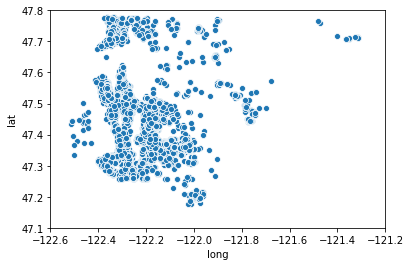

In [14]:
# Plotting houses with values less than iqr. =>Set limits so can compare easily between graphs

scatter1=sns.scatterplot(x="long",y="lat",data=df.loc[(df["price_sold"]<price_sold_25),:])
scatter1.set(ylim=(47.1,47.8),xlim=(-122.6,-121.2))

[(47.1, 47.8), (-122.6, -121.2)]

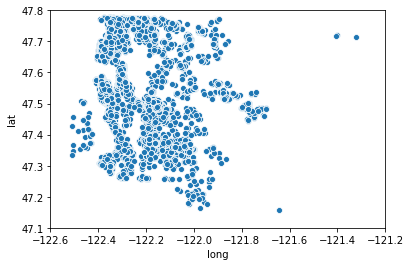

In [15]:
# Plotting second quartile

scatter2=sns.scatterplot(x="long",y="lat",data=df.loc[(df["price_sold"]<price_sold_50)
                                             &(df["price_sold"]>price_sold_25),:])
scatter2.set(ylim=(47.1,47.8),xlim=(-122.6,-121.2))

[(47.1, 47.8), (-122.6, -121.2)]

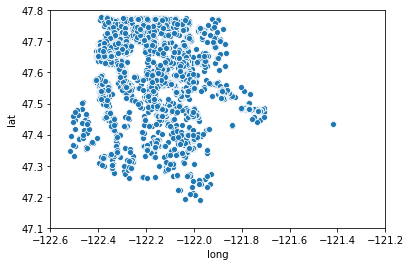

In [16]:
# Plotting third quartile

scatter3=sns.scatterplot(x="long",y="lat",data=df.loc[(df["price_sold"]<price_sold_75)
                                             &(df["price_sold"]>price_sold_50),:])
scatter3.set(ylim=(47.1,47.8),xlim=(-122.6,-121.2))

[(47.1, 47.8), (-122.6, -121.2)]

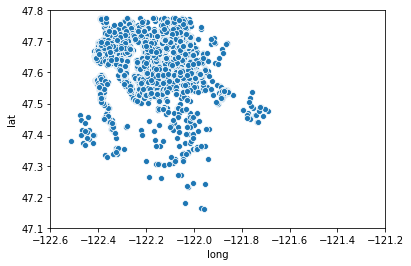

In [17]:
# Plottingfinal quartile => most expensive houses

scatter4=sns.scatterplot(x="long",y="lat",data=df.loc[(df["price_sold"]>price_sold_75),:])
scatter4.set(ylim=(47.1,47.8),xlim=(-122.6,-121.2))

In [18]:
# Can see a clear shift from the South-West to the Northern area of Kings County.
# Neighbourhood does affect the house prices

## 2) How can we categorise the houses?

We split the hosues into price quartiles. Although this was later realised to be a mistake we have left it in for completness.

In [19]:
df.columns

Index(['id', 'date_sold', 'price_sold', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view_grade', 'condition', 'grade',
       'sqft_not_basement', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living_15_neighbours',
       'sqft_lot_15_neighbours'],
      dtype='object')

In [20]:
# We need to remove any variables that cannot be manipulated after purchasing a property
# For example if the property was not by the waterfront and had a bad view 
# there's not a lot we can do to change that

df_control =df.drop(['id', 'date_sold', 'waterfront', 'view_grade', 'condition', 'grade', 'yr_built',
                     'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living_15_neighbours','sqft_lot_15_neighbours'],
                    axis=1)

In [21]:
df_control_priceq1 = df_control.loc[df_control['price_sold'] < df_control.price_sold.quantile(.25)]
df_control_priceq1.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
0,221900.0,3,1.00,1180,5650,1.0,1180,0
2,180000.0,2,1.00,770,10000,1.0,770,0
6,257500.0,3,2.25,1715,6819,2.0,1715,0
7,291850.0,3,1.50,1060,9711,1.0,1060,0
8,229500.0,3,1.00,1780,7470,1.0,1050,730


In [22]:
df_control_priceq2 = df_control.loc[(df_control['price_sold'] > df_control.price_sold.quantile(.25)) 
                                    & (df_control['price_sold'] < df_control.price_sold.quantile(.50))]
df_control_priceq2.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
9,323000.0,3,2.50,1890,6560,2.0,1890,0
13,400000.0,3,1.75,1370,9680,1.0,1370,0
16,395000.0,3,2.00,1890,14040,2.0,1890,0
20,385000.0,4,1.75,1620,4980,1.0,860,760
24,329000.0,3,2.25,2450,6500,2.0,2450,0


In [23]:
df_control_priceq3 = df_control.loc[(df_control['price_sold'] > df_control.price_sold.quantile(.5)) 
                                    & (df_control['price_sold'] < df_control.price_sold.quantile(.75))]
df_control_priceq3.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
1,538000.0,3,2.25,2570,7242,2.0,2170,400
3,604000.0,4,3.00,1960,5000,1.0,1050,910
4,510000.0,3,2.00,1680,8080,1.0,1680,0
11,468000.0,2,1.00,1160,6000,1.0,860,300
14,530000.0,5,2.00,1810,4850,1.5,1810,0


In [24]:
df_control_priceq4 = df_control.loc[df_control['price_sold'] > df_control.price_sold.quantile(.75)]
df_control_priceq4.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
5,1230000.0,4,4.50,5420,101930,1.0,3890,1530
10,662500.0,3,2.50,3560,9796,1.0,1860,1700
15,650000.0,4,3.00,2950,5000,2.0,1980,970
21,2000000.0,3,2.75,3050,44867,1.0,2330,720
26,937000.0,3,1.75,2450,2691,2.0,1750,700


We decided to split the houses down further by the number of floors they have. This will allow us to talk about cheap flats/ expensive houses etc.

It was then realised that splitting by the target variable was a bad idea as we need to act like it is an unknown. We decided to split the data into four neighbourhoods simply by drawing a grid centered on the mean location.

In [25]:
# We created a smaller dataframe of all the variables that can be controlled for,
# which we split further into the neighbourhoods 

df_location = df.drop(['id', 'date_sold', 'waterfront', 'view_grade', 'condition', 'grade', 'yr_built',
                     'yr_renovated', 'zipcode', 'sqft_living_15_neighbours','sqft_lot_15_neighbours'],
                    axis=1)

In [26]:
latmean = df_location.lat.mean()
longmean = df_location.long.mean()
display(latmean, longmean)

47.56009299439737

-122.2139824975691

In [27]:
# Choose houses in a grid

df_location1 = df_location.loc[(df_location['lat'] > latmean) & (df_location['long'] < longmean)]
df_location2 = df_location.loc[(df_location['lat'] > latmean) & (df_location['long'] > longmean)]
df_location3 = df_location.loc[(df_location['lat'] < latmean) & (df_location['long'] < longmean)]
df_location4 = df_location.loc[(df_location['lat'] < latmean) & (df_location['long'] > longmean)]

//anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


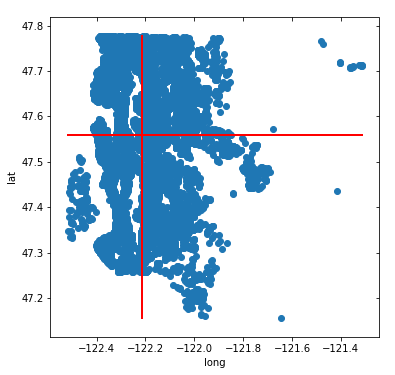

In [28]:
# The grid on a long lat plot

grid = sns.JointGrid(df.long, df.lat, space=0, size=6, ratio=50)
grid.plot_joint(plt.scatter)
plt.plot([df.long.mean(), df.long.mean()], [df.lat.min(), df.lat.max()], linewidth=2, color="r")
plt.plot([df.long.min(), df.long.max()], [df.lat.mean(), df.lat.mean()], linewidth=2, color="r")

In [29]:
# As the neighbourhoods have been set up and we can't change where houses are we dropped lat and long

df_location1 = df_location1.drop(['lat', 'long'], axis=1)
df_location2 = df_location2.drop(['lat', 'long'], axis=1)
df_location3 = df_location3.drop(['lat', 'long'], axis=1)
df_location4 = df_location4.drop(['lat', 'long'], axis=1)

## 3) For each category what are the best three variables to target in order to raise the price? Are any variables globally good?

Of the seven variables (not counting price sold) that we have left we want to find a way of picking the three with the most impact on the price. We decided that this would correspond to the model with the highest R squared value. To find the best R squared value we created a function that performed linear regresion on every combination of three variables out of our list of impactful variables.

In [30]:
# A function that can take any of our dataframes and return a sorted dataframe containing the
# R2 ranking for each group of 3 of the inputs columns


def r2(data):
    head_list = list(data.drop('price_sold', axis=1).columns)
    combins = list(itt.combinations(head_list, 3))
    r2data = pd.DataFrame()
    for i in range(len(combins)):
        headvar1 = combins[i][0]
        headvar2 = combins[i][1]
        headvar3 = combins[i][2]
        triple = '{}, {}, and {}'.format(headvar1, headvar2, headvar3)
        minidf = pd.DataFrame({headvar1:data[headvar1], headvar2:data[headvar2],
                               headvar3:data[headvar3], 'price_sold':data['price_sold']})
        X = minidf.drop('price_sold',axis=1)
        y = minidf['price_sold']

        # Setting up the LEARNER
        X = sm.add_constant(X)
        model_sm = sm.OLS(y,X)

         # Actually LEARNING
        results = model_sm.fit()

        # Evaluating performance
        r2 = results.rsquared.round(2)
        
        # Add to the R2 dataframe
        triple_r2_df = pd.DataFrame(data = {'Triples': [triple, 'delete me'], 'R_squared': [r2,'and me']})
        triple_r2_df = triple_r2_df[:1]
        
        r2data = r2data.append(triple_r2_df, ignore_index=True)
        
    r2data = r2data.set_index('Triples')
    r2data = r2data.sort_values(by=['R_squared'])
    return r2data


In [31]:
# A sorted (ascending) dataframe of R squared values for various models (within the price split)
# The R squared analysis for the price split has all be left in, the grid split analysis comes after

r2(df_control).head()

,R_squared
Triples,
"bedrooms, sqft_lot, and floors",0.15
"bedrooms, sqft_lot, and sqft_basement",0.16
"sqft_lot, floors, and sqft_basement",0.23
"bedrooms, floors, and sqft_basement",0.24
"bedrooms, bathrooms, and sqft_lot",0.28


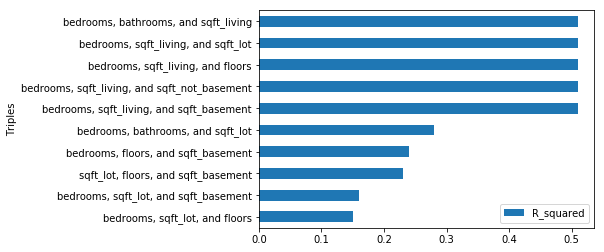

In [32]:
# Ploting the R squared values for the five worst and five best models globally without any splitting

r2(df_control)[:5].append(r2(df_control)[-5:]).plot.barh()

In the above we see that the best global price model would be one made out of bedrooms, bathrooms, and sqft living. We now want to produce one of these graphs for each of our categories so we can match a best model to each one.

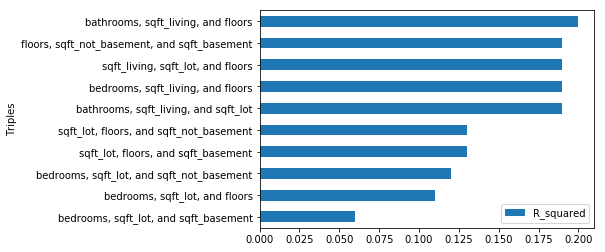

In [33]:
# The R squared values of the best and worst models in the q1 price split

r2(df_control_priceq1)[:5].append(r2(df_control_priceq1)[-5:]).plot.barh()

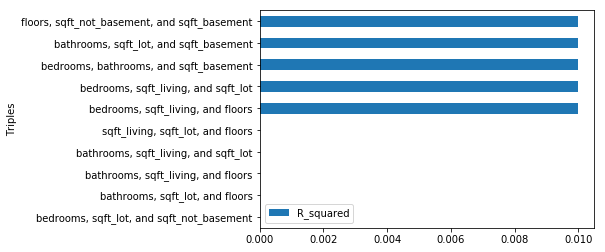

In [34]:
# The R squared values of the best and worst models in the q2 price split

r2(df_control_priceq2)[:5].append(r2(df_control_priceq2)[-5:]).plot.barh()

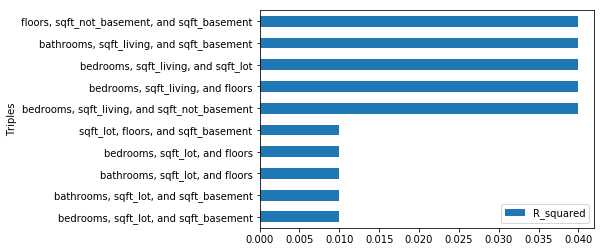

In [35]:
# The R squared values of the best and worst models in the q3 price split

r2(df_control_priceq3)[:5].append(r2(df_control_priceq3)[-5:]).plot.barh()

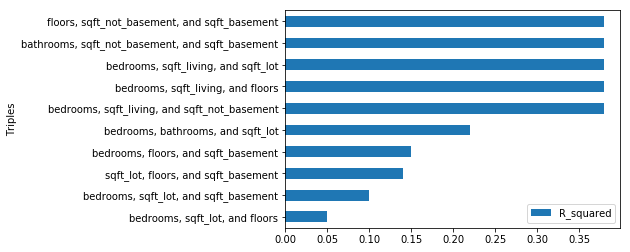

In [36]:
# The R squared values of the best and worst models in the q4 price split

r2(df_control_priceq4)[:5].append(r2(df_control_priceq4)[-5:]).plot.barh()

As the good models (in the q4 split) all have roughly similar R squared values we can choose which model to use. Let's look at the bedrooms, sqft living, and floors model in more detail.

In [37]:
df_control_priceq4.head()

,price_sold,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_not_basement,sqft_basement
5,1230000.0,4,4.50,5420,101930,1.0,3890,1530
10,662500.0,3,2.50,3560,9796,1.0,1860,1700
15,650000.0,4,3.00,2950,5000,2.0,1980,970
21,2000000.0,3,2.75,3050,44867,1.0,2330,720
26,937000.0,3,1.75,2450,2691,2.0,1750,700


//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


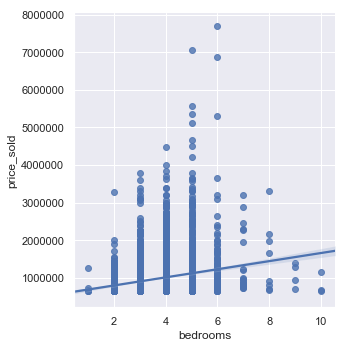

In [38]:
# Here we run seaborns inbuilt linear regression on each variable individually 
# While this doesn't provide us with a good model for price built from the variables
# we can use it as a sanity check 

q4_data = df_control_priceq4.drop(['bathrooms', 'sqft_lot', 'sqft_not_basement', 'sqft_basement'],axis=1)

Xq4 = q4_data.drop('price_sold', axis=1)

yq4 = q4_data['price_sold']

titles = ['bedrooms', 'sqft_living', 'floors']

sns.set(color_codes=True)
sns.lmplot(x='bedrooms', y='price_sold', data=q4_data)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


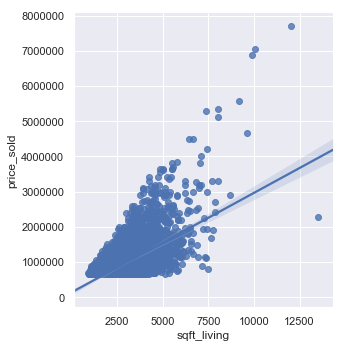

In [39]:
sns.lmplot(x='sqft_living', y='price_sold', data=q4_data)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


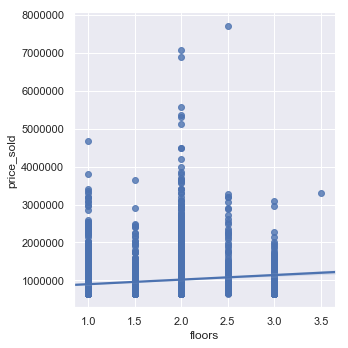

In [40]:
sns.lmplot(x='floors', y='price_sold', data=q4_data)

In [41]:
# Statsmodel linear regression applied to the combination of our three chosen variables
# This gives us the R squared values, the price intercept and the gradients of the three variables

# Setting up the LEARNER
Xq4 = sm.add_constant(Xq4)
model_sm = sm.OLS(yq4,Xq4)

# Actually LEARNING
resultsq4 = model_sm.fit()

# Evaluating performance
r2q4 = resultsq4.rsquared
r2q4 = r2q4.round(2)
print('R2 = {}'.format(r2q4))

# # Understanding the LEARNED model
est_b = resultsq4.params
print(est_b.round(4))

R2 = 0.38
const          341889.6953
bedrooms       -47456.6426
sqft_living       309.2280
floors         -58387.5377
dtype: float64


We seem to be getting terrible negative values for some of the gradients! This completely goes against what our seaborn linear regression models suggested. What's going on is that we haven't checked for correlation between the variables. As we're trying to construct a model for price out of three similar things we are in effect over counting. This causes our statsmodel linear regression to go haywire and spit out nonsense numbers for the gradient. We certainly don't want to put forth a model that says the best way to make a profit is to remove floors from your property!

For completness we include below the same analysis run over our more informed geographically chosen neighbourhoods. The takeaway is much the same, with strong negative gradients for most of our variables.

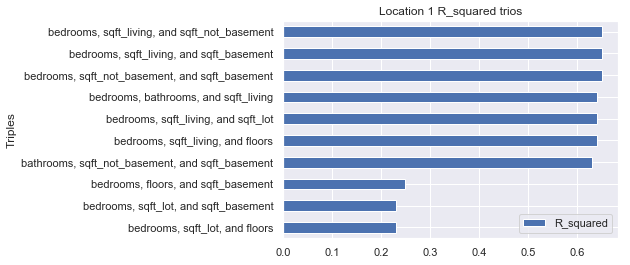

In [43]:
r2(df_location1)[:3].append(r2(df_location1)[-7:]).plot.barh(title = 'Location 1 R_squared trios')

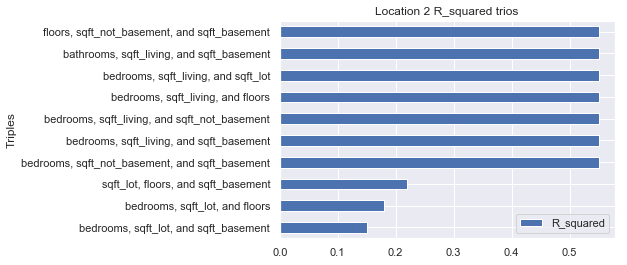

In [44]:
r2(df_location2)[:3].append(r2(df_location2)[-7:]).plot.barh(title = 'Location 2 R_squared trios')

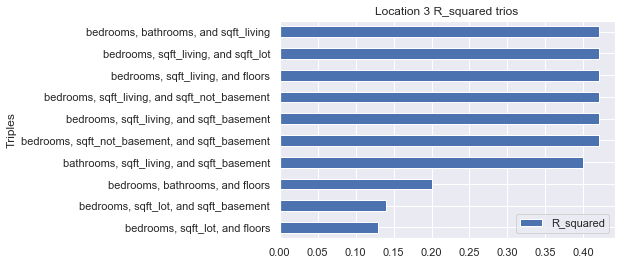

In [45]:
r2(df_location3)[:3].append(r2(df_location3)[-7:]).plot.barh(title = 'Location 3 R_squared trios')

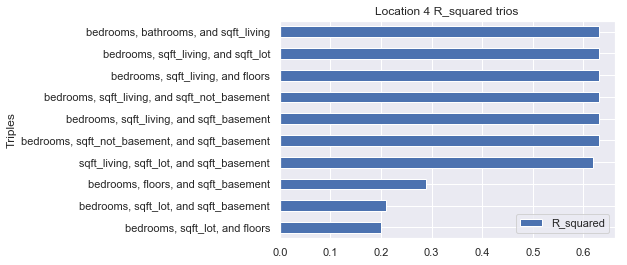

In [46]:
r2(df_location4)[:3].append(r2(df_location4)[-7:]).plot.barh(title = 'Location 4 R_squared trios')

Looking at the location 1 data set we see that most of the 'good' models have very similar R squared values so we're free to choose one to build a model with. For the purpose of exploration we chose the trio of bedrooms, bathrooms, and sqft living size to perform linear regression on.

In [47]:
# Setting up a dataframe for the bedrooms, bathrooms, and sqft living model.

df_location1_model1 = df_location1.drop(['sqft_lot', 'floors', 
                                         'sqft_not_basement', 'sqft_basement'],axis=1)

Xl1 = df_location1_model1.drop('price_sold', axis=1)

yl1 = df_location1_model1['price_sold']

In [48]:
# lin reg for location 1 and bedrooms, bathrooms, sqft living size model

# Setting up the LEARNER
Xl1 = sm.add_constant(Xl1)
model_sm_l1 = sm.OLS(yl1,Xl1)

# Actually LEARNING
resultsl1 = model_sm_l1.fit()

# Evaluating performance
r2l1 = resultsl1.rsquared
r2l1 = r2l1.round(2)
print('R2 = {}'.format(r2l1))

# # Understanding the LEARNED model
est_b = resultsl1.params
print(est_b.round(4))

R2 = 0.64
const          70405.9215
bedrooms      -86422.8081
bathrooms      -1371.8150
sqft_living      444.7181
dtype: float64


Again we see that we have wild negative gradients in our model, surely adding bedrooms won't take 86 grand off of the price. 

We then decided to tweak the r2 fucntion so that it also procuded a second column containing the average correlation of the elements of the model. The model picking stategy would then become look at all the models with the highest R squared then choose the one with the lowest average correlation.

In [62]:
# A function that can take any of our dataframes and return a sorted dataframe containing the
# R2 ranking for each group of 3 of the inputs columns
# Now with added co correlation functionality!


def r2_with_corr(data):
    head_list = list(data.drop('price_sold', axis=1).columns)
    combins = list(itt.combinations(head_list, 3))
    r2data = pd.DataFrame()
    for i in range(len(combins)):
        headvar1 = combins[i][0]
        headvar2 = combins[i][1]
        headvar3 = combins[i][2]
        triple = '{}, {}, and {}'.format(headvar1, headvar2, headvar3)
        minidf = pd.DataFrame({headvar1:data[headvar1], headvar2:data[headvar2],
                               headvar3:data[headvar3], 'price_sold':data['price_sold']})
        X = minidf.drop('price_sold',axis=1)
        y = minidf['price_sold']

        # Setting up the LEARNER
        X = sm.add_constant(X)
        model_sm = sm.OLS(y,X)

         # Actually LEARNING
        results = model_sm.fit()

        # Evaluating performance
        r2 = results.rsquared.round(2)
        
        # Averaging the correlation
        cor1 = data.corr()[headvar1][headvar2]
        cor2 = data.corr()[headvar1][headvar3]
        cor3 = data.corr()[headvar2][headvar3]
        
        corav = (cor1 + cor2 + cor3)/3

        
        # Add to the R2 dataframe
        triple_r2_df = pd.DataFrame(data = {'Triples': [triple, 'delete me'], 
                                            'R_squared': [r2,'and me'],
                                            'Average Correlation': [corav, 'and me']})
        triple_r2_df = triple_r2_df[:1]
        
        r2data = r2data.append(triple_r2_df, ignore_index=True)
        
    r2data = r2data.set_index('Triples')
    r2data = r2data.sort_values(by=['R_squared', 'Average Correlation'], ascending=[True, False])
    return r2data


In [65]:
r2_with_corr(df_location1).tail()

,R_squared,Average Correlation
Triples,,
"bedrooms, sqft_living, and sqft_lot",0.64,0.392165
"bedrooms, sqft_living, and floors",0.64,0.302006
"bedrooms, sqft_living, and sqft_not_basement",0.65,0.669655
"bedrooms, sqft_living, and sqft_basement",0.65,0.540986
"bedrooms, sqft_not_basement, and sqft_basement",0.65,0.3527


So we see that the model that predicts the price in location one best is made out of bedrooms, sqft_not_basement, and sqft_basement. This model has the highest R squared (measure of confidence in the model) and lowest correlation between variables.

Lets now see how it does run through our multivariable linear regression.

In [66]:
# Setting up a dataframe for the bedrooms, sqft_not_basement, and sqft_basement.

df_location1_model2 = df_location1.drop(['sqft_lot', 'floors', 
                                         'bathrooms', 'sqft_living'],axis=1)

Xl1_2 = df_location1_model2.drop('price_sold', axis=1)

yl1_2 = df_location1_model2['price_sold']

In [68]:
# Actually running the linear regression

# Setting up the LEARNER
Xl1_2 = sm.add_constant(Xl1_2)
model_sm_l1_2 = sm.OLS(yl1_2,Xl1_2)

# Actually LEARNING
resultsl1_2 = model_sm_l1_2.fit()

# Evaluating performance
r2l1_2 = resultsl1_2.rsquared
r2l1_2 = r2l1_2.round(2)
print('R2 = {}'.format(r2l1_2))

# # Understanding the LEARNED model
est_b = resultsl1_2.params
print(est_b.round(4))

R2 = 0.65
const                30912.9121
bedrooms            -85006.8562
sqft_not_basement      492.4075
sqft_basement          332.2915
dtype: float64


It's still not great!